### 🎯 Goal

Build a **Planner → Researcher → Writer** multi-agent workflow using LangGraph.

Flow:

```
User → Planner → Researcher → Writer → Final Output
```

Each agent is just an **LLM with a different system prompt**.
All communication happens through the shared **MessagesState**.

---

### 🧠 Key Idea

We do *not* need separate state objects.
We only need:

* Different node functions
* Different system prompts applied at those nodes
* A fixed graph order: `planner → researcher → writer → END`

No tool use yet (we add tools back in Stage 4).

In [5]:
from langgraph.graph import StateGraph, MessagesState, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage
from dotenv import load_dotenv
load_dotenv("../../config/local.env")

True

In [6]:
llm = ChatOpenAI(model="gpt-4o-mini")

In [7]:

# System prompts (define agent roles)

PLANNER_PROMPT = SystemMessage(
    content="You are the Planner Agent. Break the user's query into 1–3 clear research steps."
)

RESEARCHER_PROMPT = SystemMessage(
    content="You are the Research Agent. For each step, gather relevant factual information. Be concise."
)

WRITER_PROMPT = SystemMessage(
    content="You are the Writer Agent. Combine the research output into a clear final answer."
)

In [11]:
# Agent Nodes

def planner_node(state: MessagesState):
    user_message = state["messages"][-1]
    response = llm.invoke([PLANNER_PROMPT, user_message])
    print("\n📝 Planner Output:\n", response.content)
    return {"messages": state["messages"] + [response]}

def researcher_node(state: MessagesState):
    messages = state["messages"]
    response = llm.invoke([RESEARCHER_PROMPT] + messages)
    print("\n🔍 Researcher Output:\n", response.content)
    return {"messages": messages + [response]}

def writer_node(state: MessagesState):
    messages = state["messages"]
    response = llm.invoke([WRITER_PROMPT] + messages)
    print("\n✍️ Writer Output:\n", response.content)
    return {"messages": messages + [response]}


In [12]:

builder = StateGraph(MessagesState)
builder.set_entry_point("planner")

builder.add_node("planner", planner_node)
builder.add_node("researcher", researcher_node)
builder.add_node("writer", writer_node)

builder.add_edge("planner", "researcher")
builder.add_edge("researcher", "writer")
builder.add_edge("writer", END)

graph = builder.compile()

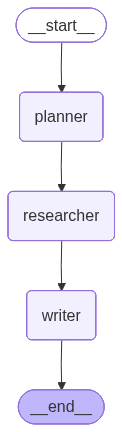

In [ ]:
graph

In [13]:
# Run example

query = "Explain how solar panels generate electricity in simple terms."
result = graph.invoke({"messages": [{"role": "user", "content": query}]})

print("\n🤖 Final Answer:\n", result["messages"][-1].content)



📝 Planner Output:
 1. **Understand the Basics of Solar Energy**: Research how solar energy is harnessed from the sun and the concept of photons.

2. **Learn About Photovoltaic Cells**: Investigate how photovoltaic (PV) cells in solar panels convert sunlight into electricity.

3. **Explore the Electricity Generation Process**: Find out how the electricity generated by solar panels is then used, stored, or distributed.

🔍 Researcher Output:
 1. **Solar Energy Basics**: Solar panels harness energy from the sun, specifically from sunlight, which consists of tiny particles called photons. When sunlight hits a solar panel, it contains energy that can be converted into electricity.

2. **Photovoltaic Cells**: Solar panels are made up of many photovoltaic (PV) cells. These cells are typically made of silicon and create an electric field. When photons from sunlight strike the silicon in the PV cells, they knock electrons loose, creating an electric current.

3. **Electricity Generation Process

✅ What we Just Built

- 3 agents, each with a role-specific prompt.

- A sequential reasoning pipeline.

- Clear division of responsibilities:

    - Planner → task decomposition

    - Researcher → knowledge gathering

    - Writer → synthesis

This is already the core pattern behind enterprise copilots.